# Using pypardiso as an external sparse direct solver for PyFVTool

---

MW, 230908, 240503

250620: Special modified version to test PyPardiso fix for NumPy2



---

This is an example of how to use an external sparse solver with PyFVTool. It is also a draft for future documentation on the subject, as part of the PyFVTool documentation.

An external solver can be supplied as an optional argument to `pyfvtool.solvePDE()`, *e.g.*

```python
pf.solvePDE(phi, eqnterms,
            externalsolver = solveur)
```

where `solveur` is a function that will be called instead of `scipy.sparse.linalg.spsolve(A, b)`. In this example, we use `pypardiso.spsolve(A, b)`.


## Install pypardiso

[`pypardiso`](https://github.com/haasad/PyPardisoProject) is a simple Python interface to the [Intel MKL PARDISO solver](https://www.intel.com/content/www/us/en/docs/onemkl/developer-reference-c/2023-2/onemkl-pardiso-parallel-direct-sparse-solver-iface.html)

250620: Special modified version to test PyPardiso fix for NumPy2 (https://github.com/haasad/PyPardiso/pull/79)

First, prepare your conda environment with NumPy 2.x etc.

Finally, install PyPardiso as the last package, and use `pip` to get the specially patched version:

```
pip install git+https://github.com/urob/PyPardiso.git@fix-type-mismatch
```


## Test drive pypardiso

Using the example from the pypardiso README.

In [1]:
import sys
import numpy as np
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt
import pypardiso

pypardiso version 0.4.6 or later is required!

In [2]:
print('Python', sys.version)
print('NumPy version    : ', np.__version__)
print('SciPy version    : ', sp.__version__)
print('PyPardiso version: ', pypardiso.__version__)

Python 3.12.9 | packaged by conda-forge | (main, Mar  4 2025, 22:37:18) [MSC v.1943 64 bit (AMD64)]
NumPy version    :  2.3.0
SciPy version    :  1.15.2
PyPardiso version:  0.1.dev230+gaf15ab2


In [3]:
A = sparse.rand(10, 10, density=0.5, format='csr')

In [4]:
b = np.random.rand(10)

In [5]:
x = pypardiso.spsolve(A, b)

In [6]:
x

array([-2.3764147 ,  1.73068708,  2.29913807,  2.93610322, -2.76931923,
       -0.14429342, -1.87184444, -2.13042486,  0.70578461,  1.89171707])

## PyFVTool finite-volume (from cylindrical2D_convection notebook)

In [7]:
from time import time
import pyfvtool as pf

#### Utility functions

In [8]:
# visualization routine (imshow-based)
def phi_visualize():
    print(f't = {t:.1f} s')
    # avoid ghost cells
    plt.imshow(phi.value, origin = 'lower',
               extent = [zz[0], zz[-1], rr[0]*rzoom, rr[-1]*rzoom])

In [9]:
# calculate simple finite-volume integral over r
def integral_dr(phi0):
    v = phi0.cellvolume
    c = phi0.value
    return (v*c).sum(axis=0)

#### FVM settings

In [10]:
Lr = 7.5e-05 # [m] radius of cylinder
Lz = 0.3 # [m] length of cylinder
umax = 2*9.4314e-3 # [m s^-1] max flow velocity = 2 time average flow velocity

In [11]:
# regular grid parameters
Nr = 40
Nz = 500

In [12]:
# initial condition parameters (cell indices)
loadix0 = 20
loadix1 = 40

In [13]:
# timestep parameters
deltat = 0.01 # [s] per time step

In [14]:
# visualization parameters
rzoom = 1000

#### 2D cylindrical mesh

In [15]:
msh = pf.CylindricalGrid2D(Nr, Nz, Lr, Lz)

#### Set up Poiseuille flow velocity field

In [16]:
rr = msh.cellcenters.r
zz = msh.facecenters.z

In [17]:
uu =  umax*(1 - (rr**2)/(Lr**2)) # does not depend on zz

In [18]:
u =  pf.FaceVariable(msh, 1.0)

In [19]:
u.rvalue[:] = 0
u.zvalue[:] = uu[:, np.newaxis]

#### Solution variable

In [20]:
bc = pf.BoundaryConditions(msh)

In [21]:
phi = pf.CellVariable(msh, 0.0 , bc)

#### Initial condition

In [22]:
t=0.

In [23]:
# initial condition
for i in range(loadix0, loadix1):
    phi.value[:, i] = 1.0

t = 0.0 s


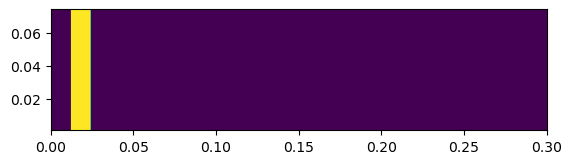

In [24]:
phi_visualize()

In [25]:
initInt = phi.domainIntegral()
# print(initInt)

In [26]:
phiprofs = []
phiprofs.append((t, integral_dr(phi)))

### Solve the convection PDE with time-stepping

In [27]:
exect0 = time()

In [28]:
# The convection term only needs to be constructed once, since it
# will be constant during all time steps.
# convectionterm = pf.convectionTerm(u) # really ugly results?
convectionterm = pf.convectionUpwindTerm(u) # numerical diffusion

def step_solver(Nstp):
    global t

    for i in range(Nstp):
        # Transient term needs to be re-evaluated at each time step
        transientterm = pf.transientTerm(phi, deltat, 1.0)
        eqnterms = [transientterm,
                    convectionterm]
        # solve the PDE using pypardiso.spsolve as the external solver
        pf.solvePDE(phi, eqnterms,
                    externalsolver = pypardiso.spsolve)
        t += deltat

In [29]:
step_solver(200)
phiprofs.append((t, integral_dr(phi)))

In [30]:
# print(t, initInt, pf.domainInt(phi))
# test conservation of mass
assert np.isclose(initInt, phi.domainIntegral())

t = 2.0 s


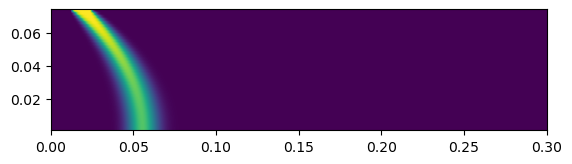

In [31]:
phi_visualize()

In [32]:
step_solver(300)
phiprofs.append((t, integral_dr(phi)))

In [33]:
step_solver(500)
phiprofs.append((t, integral_dr(phi)))

In [34]:
print(t, initInt, phi.domainIntegral())

9.999999999999831 2.1205750411731096e-10 2.1205750411729896e-10


t = 10.0 s


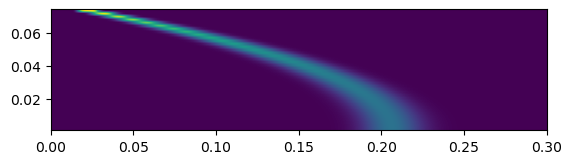

In [35]:
phi_visualize()

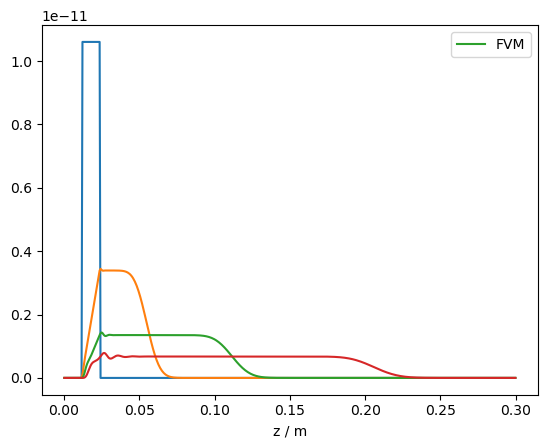

In [36]:
for ix, (tprof, phiprof) in enumerate(phiprofs):
    if ix == 2:
        lbl1 = 'FVM'
    else:
        lbl1 = None
    plt.plot(phi.domain.cellcenters.z, phiprof, 
             label=lbl1)
plt.xlabel('z / m')
plt.legend();

In [37]:
exect1 = time()

In [38]:
print('Elapsed time ', exect1 - exect0, 's')

Elapsed time  29.062185287475586 s


In [39]:
# Execution time benchmark results 
#    - Werts' computer (in 'best performance' power management mode)
#
# Elapsed time  2.36826229095459  s (pypardiso.spsolve via solveur function)
# Elapsed time  5.680087327957153 s (scipy.sparse.linalg.spsolve SuperLU)